### <span style="color: green;">Importations</span>

In [2]:
import gymnasium as gym            # Pour l'environnement
import numpy as np                 # Pour les calculs
import matplotlib.pyplot as plt    # Pour les graphes
from collections import deque      # Pour le memory buffer
import random                      # Pour le epsilon greedy
import torch                       # Pour les reseaux de neuronnes et fonction de retropropagation
from torch import nn               #
import torch.nn.functional as F    #
from tqdm import tqdm              # Pour le trace de la barre de progres

pygame 2.6.1 (SDL 2.28.4, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


<div style="text-align: center;">
    <h1>Algorithme de Deep Q-Network</h1>
</div>

### Classe des reseaux de neuronnes (2 reseaux de neuronnes: Q-training et Q-target)

In [3]:
###########################################################################################################################################
####### Les 2 reseaux de neuronnes sont convolutifs car ils vont devoir prendre en entree un Etat qui est une observations de       #######
####### l'envionnement par l'agent. Cette observations est au format image (7x7x3): Une grille de 7x7 cases qui comportent 3 canaux #######
#######                               (Type d'objet, Couleur, Etat (ouvert/fermé))                                                  #######
###########################################################################################################################################
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 256)  # Aplatir la sortie des convolutions
        self.fc2 = nn.Linear(256, 3)  # Nombre d'actions toujours égal à 3

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Aplatir le tenseur pour la couche entièrement connectée
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Classe du Replay buffer

In [4]:
###########################################################################################################################################
########################## Le Replay Buffer va contenir les informations des exepriences de l'agent :   ###################################
##########################          (Etat, action, recompense, Nouvel Etat, Termine?)                   ###################################
########################## Ce Buffer sera utile lors de la backpropagation et permettra ainsi à l'agent ###################################
##########################        d'apprendre de ses experiences en modifiant sa Training Policy        ###################################
###########################################################################################################################################
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):   # pour obtenir un echantillon de taille sample_size de la memoire
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

### Classe Environnement

In [5]:
class Minigrid():
    
    # Hyperparametres (ajustables)
    learning_rate_a = 0.001         # Facteur d'apprentissage (learning rate, alpha)
    discount_factor_g = 0.9         # Facteur d'actualisation (discount rate, gamma)
    replay_memory_size = 1000       # Taille de la mémoire de replay
    network_sync_rate = 10          # Nombre d'étapes que l'agent effectue avant de synchroniser le Q-training et le Q-target
    mini_batch_size = 32            # Nombre de transitions effectuées et stockées dans le buffer pour constituer un mini-batch
                                    # après avoir été mélangé
    # Reseaux de Neuronnes
    loss_fn = nn.MSELoss()          # RN: fonction de perte (Loss) MSE=Mean Squared Error 
    optimizer = None                # RN: Optimizer. Initialize later.

    # Pour Print 0,1,2 => Left, Right, Forward
    ACTIONS = ['Left', 'Right', 'Forward']    


#################################################################################################################################
########################## Fonction d'Entainement qui va effectuer plusieurs Tests sous forme   ################################# 
########################## d'Episodes et ainsi Ameliore la Policy de L'Agent au fur et à mesure #################################
#################################################################################################################################
    
    # Entraîner dans l'environnement
    def train(self, episodes, render="rgb_array"):
        
        # Créer l'environnement MiniGrid avec un rendu visuel
        env = gym.make("MiniGrid-Empty-5x5-v0", render_mode=render)
        observation, info = env.reset(seed=42)
        epsilon = 1  # 1 = 100% actions aléatoires au départ, puis qui va progressivement diminuer au fil des test
        
        # Création du memory Buffer
        memory = ReplayMemory(self.replay_memory_size) 

        # Création des réseaux de neurones training et target
        training_dqn = DQN() 
        target_dqn = DQN()   
        # Au démarrage, les 2 réseaux de neurones sont identiques (copie de biais/poids de training vers target)
        target_dqn.load_state_dict(training_dqn.state_dict())

        # L'optimizer du réseau de training, choisi en Adam mais peut être changé
        self.optimizer = torch.optim.Adam(training_dqn.parameters(), lr=self.learning_rate_a)

        # Liste des récompenses à garder au fil des épisodes. Initialisée comme une liste de zéros.
        rewards_per_episode = np.zeros(episodes)
        rewards = 0

        # Liste des epsilones à conserver
        epsilon_history = []

        # Information du nombre d'étapes effectuées. Pour synchroniser: Target <= Training
        step_count = 0

        ############################################### Training ################################################################
        for i in tqdm(range(episodes), desc="Entraînement"):
            observation, info = env.reset(seed=42)  # Initialise l'agent à l'état 0 qui correspond à la case en haut à gauche
            
            # Transformer l'observation en format adapté au CNN
            state = torch.tensor(observation['image'], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # format (1, 3, 7, 7)
            
            terminated = False  # True quand l'agent arrive au bout
            truncated = False   # True quand l'agent fait plus de 200 actions (qu'il se perd)   

            ################################# On entre dans la boucle d'un Episode ##################################
            # L'agent effectue des transitions jusqu'a ce qu'il arrive au bout ou se perde             
            while(not terminated and not truncated):
                
                # 1. L'agent choisit une action selon sa behavior policy qui est ici un epsilon greedy
                if random.random() < epsilon:
                    # Action Aleatoire               
                    action = random.randint(0, 2) # actions: 0=left,1=down,2=right,3=up
                else:
                    # Action Optimale            
                    with torch.no_grad():
                        action = training_dqn(state).argmax().item()

                # 2. Exécuter l'action dans l'environnement
                new_observation, reward, terminated, truncated, _ = env.step(action)

                # 3. Transformer la nouvelle observation en format compatible avec le CNN
                new_state = torch.tensor(new_observation['image'], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        
                # 4. Stocker la transition dans le Replay Buffer
                memory.append((state, action, reward, new_state, terminated)) 

                # 5. Entraîner le réseau si suffisamment d'expériences sont disponibles
                if len(memory) > self.mini_batch_size:
                    mini_batch = memory.sample(self.mini_batch_size)     # Échantillonner un mini-batch
                    self.optimize(mini_batch, training_dqn, target_dqn)  # Optimiser le réseau

                # 6. Mettre à jour l'état actuel pour la prochaine itération
                state = new_state
                
                # 7. Compter le nombre d'actions réalisées
                step_count += 1
            #################################### On sort de l'Episode ################################################
            
            # Stocker la récompense obtenue dans cet épisode
            rewards = rewards + reward
            rewards_per_episode[i] = rewards      

            # Décroître l'epsilon pour favoriser l'exploitation
            epsilon = max(epsilon - 1/episodes, 0)
            epsilon_history.append(epsilon)
            
            # Synchroniser le Target Network avec le Training Network en fonction du network_sync_rate
            if i % self.network_sync_rate == 0:
                target_dqn.load_state_dict(training_dqn.state_dict())
        ########################################################################################################################

        # Ferme l'environment
        env.close()

        # Sauvegarder le Training Network
        torch.save(training_dqn.state_dict(), "Minigrid.pt")

        # Tracer des recompenses (Y-axis) vs Episodes (X-axis)
        plt.plot(rewards_per_episode)
        plt.title("Récompenses par épisode")
        plt.xlabel("Épisode")
        plt.ylabel("Récompense")
        plt.show()
        
        # Tracer Epsilon(Y-axis) vs Episodes (X-axis)
        plt.plot(epsilon_history)
        plt.show()




#################################################################################################################################
########################## Fonction d'Optimisation qui va effectuer une retropropagation sur le ################################# 
##########################        Training Network à partir d'un mini Batch de 32 tests         #################################
#################################################################################################################################

    # Fonction de rétropropagation du training Network
    def optimize(self, mini_batch, training_dqn, target_dqn):
        # Initialisation des listes pour les Q-values courantes et cibles
        current_q_list = []
        target_q_list = []

        ######################################## Formule des Deep Q Network ###############################################
        for state, action, reward, new_state, terminated in mini_batch:

            # Obtenir les valeurs Q courantes pour l'état actuel
            current_q = training_dqn(state)  # Ici, state_tensor est de la forme (1, 3, 7, 7)
            current_q_list.append(current_q)

            if terminated:
                # Si l'état est terminé, la valeur cible est simplement la récompense
                target = torch.FloatTensor([reward])  # Convertir la récompense en tenseur
            else:
                # Sinon, calculer la valeur cible en utilisant le réseau cible
                with torch.no_grad():
                    # Calculer la valeur cible
                    target = reward + self.discount_factor_g * target_dqn(new_state).max()
                    target = torch.FloatTensor([target])  # Convertir en tenseur

            # Obtenir les valeurs Q cibles pour l'état actuel
            target_q = current_q.clone()  # Créer une copie des valeurs Q courantes
            target_q[0][action] = target  # Ajuster l'action correspondante à la valeur cible
            target_q_list.append(target_q)
        ###################################################################################################################

        # Calculer la perte pour le mini-batch entier
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimiser le modèle
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



#################################################################################################################################
############################## Fonction de Test qui affiche en temps reel les essaies et qui  ################################### 
##############################            s'appuit sur la Politique entrainee                 ###################################
#################################################################################################################################

    # Fonction de Test avec la politique apprise
    def test(self, episodes, render="human"):
        # Créer l'environnement MiniGrid avec le rendu souhaité
        env = gym.make("MiniGrid-Empty-5x5-v0", render_mode=render)
    
        # Charger la politique apprise
        policy_dqn = DQN()  
        policy_dqn.load_state_dict(torch.load("Minigrid.pt"))
        policy_dqn.eval()  # Passer le modèle en mode évaluation (pas de mise à jour des poids)

        for i in range(episodes):
            observation, info = env.reset(seed=42)  # Réinitialiser l'environnement à l'état de départ
            state = torch.tensor(observation['image'], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Transformer l'observation
            terminated = False  # L'agent a atteint l'objectif ou une condition de fin
            truncated = False   # L'agent a pris trop de mesures

            # L'agent navigue jusqu'à atteindre une condition de fin
            while(not terminated and not truncated):  
                # Sélectionner la meilleure action selon la politique apprise
                with torch.no_grad():
                    action = policy_dqn(state).argmax().item()

                # Exécuter l'action
                new_observation, reward, terminated, truncated, _ = env.step(action)

                # Transformer la nouvelle observation en format compatible avec le CNN
                new_state = torch.tensor(new_observation['image'], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

                # Mettre à jour l'état actuel
                state = new_state

        env.close()

## *Main*

Entraînement: 100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


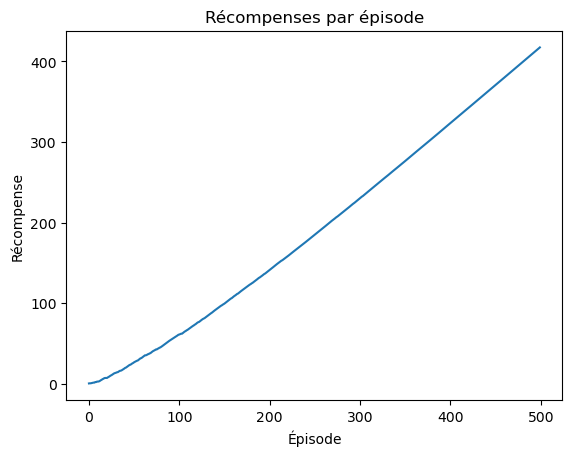

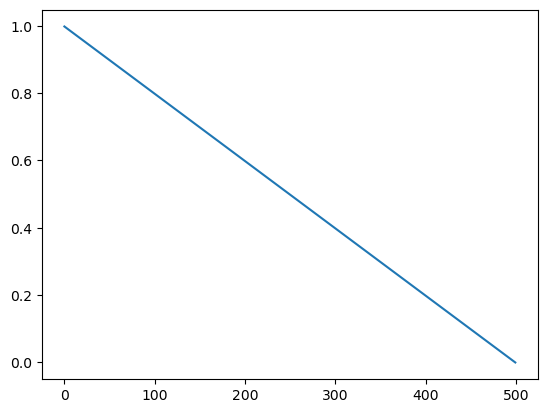

In [6]:
if __name__ == '__main__':
    
    Minigrid = Minigrid()
    Minigrid.train(500)
    Minigrid.test(5)